In [46]:
from my_utils.base_data_handler import BaseDataHandler #type: ignore
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [47]:
handler = BaseDataHandler('data/raw/tracks_raw.csv')

In [48]:
handler.try_clean_column_names()
handler.df.nunique()

unnamed_0           114000
track_id             89741
artists              31437
album_name           46589
track_name           73608
popularity             101
duration_ms          50697
explicit                 2
danceability          1174
energy                2083
key                     12
loudness             19480
mode                     2
speechiness           1489
acousticness          5061
instrumentalness      5346
liveness              1722
valence               1790
tempo                45653
time_signature           5
track_genre            114
dtype: int64

In [49]:
import unicodedata
import re


def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    s = re.sub(r"\(.*?\)|\[.*?\]", "", s)  # remove brackets
    s = re.sub(r"\s+", " ", s)
    return s.strip()
# create a duplication key
handler.try_add_col(target_col="duration_s", func=lambda x: x["duration_ms"]/1e3)
print(handler.try_add_col('song_key', lambda row: f"{normalize_text(row['artists'])}+{normalize_text(row['track_name'])}+{str(row['duration_s'])}"))

handler.df.drop_duplicates(subset=['song_key'], inplace=True)
handler.df.drop_duplicates(subset=['track_id'], inplace=True)
handler.df.info()

(True, None)
<class 'pandas.core.frame.DataFrame'>
Index: 82775 entries, 0 to 113999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unnamed_0         82775 non-null  int64  
 1   track_id          82775 non-null  object 
 2   artists           82774 non-null  object 
 3   album_name        82774 non-null  object 
 4   track_name        82774 non-null  object 
 5   popularity        82775 non-null  int64  
 6   duration_ms       82775 non-null  int64  
 7   explicit          82775 non-null  bool   
 8   danceability      82775 non-null  float64
 9   energy            82775 non-null  float64
 10  key               82775 non-null  int64  
 11  loudness          82775 non-null  float64
 12  mode              82775 non-null  int64  
 13  speechiness       82775 non-null  float64
 14  acousticness      82775 non-null  float64
 15  instrumentalness  82775 non-null  float64
 16  liveness          82775 non-nul

In [50]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

features = [
    'tempo',
    'energy',
    'danceability',
    'valence',
    'acousticness'
]

X = StandardScaler().fit_transform(handler.df[features])



In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X)

handler.df['pc1'] = components[:, 0]
handler.df['pc2'] = components[:, 1]


In [52]:
from sklearn.cluster import KMeans

k=5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

handler.df['cluster'] = kmeans.fit_predict(X)

In [53]:
x = handler.df['pc1'] - handler.df['pc1'].mean()
y = handler.df['pc2'] - handler.df['pc2'].mean()

r = (x**2 + y**2) ** 0.5
handler.df['x_circle'] = x / r.max()
handler.df['y_circle'] = y / r.max()


In [54]:
# Mark duplicates
handler.df['is_duplicate'] = handler.df.duplicated(
    subset=['track_name', 'artists', 'duration_ms'],
    keep=False
)

# Smaller base size, slightly larger duplicates
handler.df['point_size'] = handler.df['is_duplicate'].apply(lambda x: 45 if x else 15)


In [55]:
import numpy as np

np.random.seed(42)

jitter_strength = 0.02  # small, safe value

handler.df['x_plot'] = handler.df['x_circle'] + np.random.normal(0, jitter_strength, len(handler.df))
handler.df['y_plot'] = handler.df['y_circle'] + np.random.normal(0, jitter_strength, len(handler.df))


In [56]:
cluster_profiles = (
    handler.df.groupby('cluster')[[
        'energy',
        'danceability',
        'valence',
        'acousticness',
        'tempo'
    ]]
    .mean()
)

In [57]:
def name_cluster(row, global_means):
    if row['energy'] > global_means['energy'] and row['danceability'] > global_means['danceability']:
        return "High-energy / Dance"
    if row['acousticness'] > global_means['acousticness'] and row['energy'] < global_means['energy']:
        return "Acoustic / Chill"
    if row['valence'] > global_means['valence']:
        return "Happy / Upbeat"
    if row['energy'] < global_means['energy'] and row['valence'] < global_means['valence']:
        return "Calm / Moody"
    return "Balanced / Mixed"


In [58]:
global_means = handler.df[[
    'energy',
    'danceability',
    'valence',
    'acousticness',
    'tempo'
]].mean()

cluster_names = {
    cluster: name_cluster(cluster_profiles.loc[cluster], global_means)
    for cluster in cluster_profiles.index
}

handler.df['cluster_name'] = handler.df['cluster'].map(cluster_names)


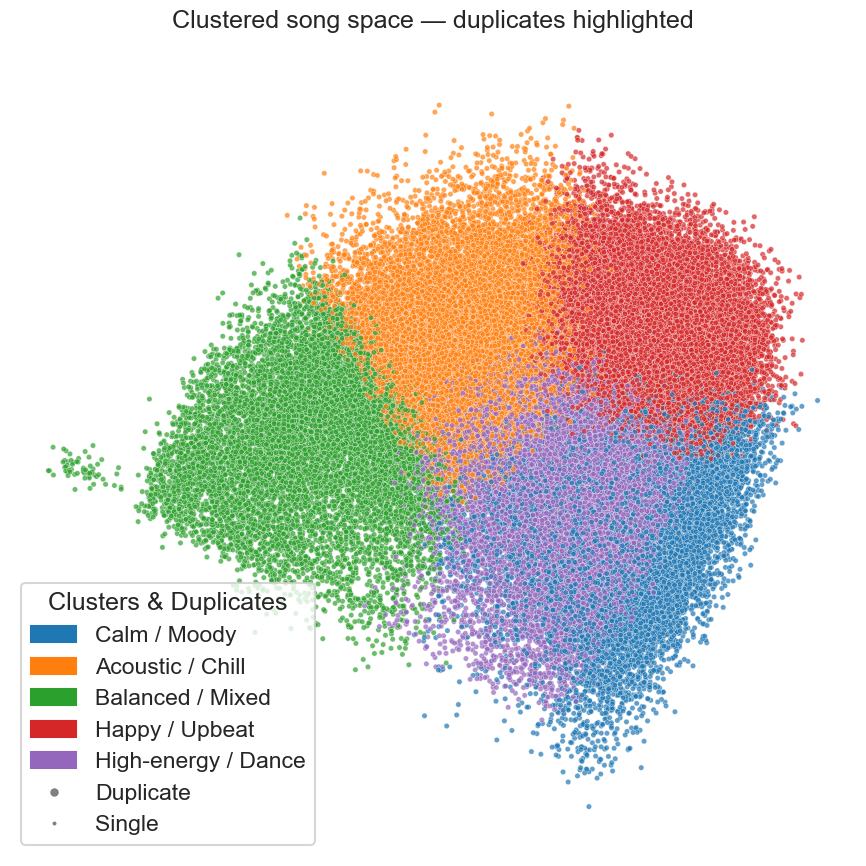

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

sns.set(style="white", context="talk")

plt.figure(figsize=(9,9))

# --- Scatterplot: use numeric cluster for hue ---
# keep all points visible
palette = sns.color_palette("tab10", n_colors=handler.df['cluster'].nunique())

scatter = sns.scatterplot(
    data=handler.df,
    x='x_plot',
    y='y_plot',
    hue='cluster',              # numeric cluster ensures all clusters appear
    palette=palette,
    size='point_size',
    sizes=(15,50),
    alpha=0.7,
    legend=False
)

plt.axis('equal')
plt.axis('off')
plt.title("Clustered song space — duplicates highlighted", pad=20)

# --- Legend with readable cluster names ---
cluster_names = {
    4: "High-energy / Dance",
    1: "Acoustic / Chill",
    3: "Happy / Upbeat",
    0: "Calm / Moody",
    2: "Balanced / Mixed"
}

# Color handles for clusters
cluster_handles = [
    Patch(color=palette[i], label=cluster_names[i])
    for i in range(len(cluster_names))
]

# Size handles for duplicates
size_handles = [
    Line2D([0], [0], marker='o', color='w', label='Duplicate',
           markerfacecolor='gray', markersize=np.sqrt(50)),
    Line2D([0], [0], marker='o', color='w', label='Single',
           markerfacecolor='gray', markersize=np.sqrt(15))
]

# Combine legends
plt.legend(handles=cluster_handles + size_handles, title="Clusters & Duplicates",
           loc="lower left", frameon=True)

plt.tight_layout()
plt.show()
